In [1]:
pip install transformers datasets pandas scikit-learn

In [2]:
!pip install --upgrade transformers

In [3]:
import pandas as pd
import numpy as np
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

In [6]:
!pip install numpy==1.26.4 --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 108.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
print("NumPy version:", np.__version__)

NumPy version: 1.26.4


In [6]:
# ----------------------
# Step 1: Load and Clean Data
# ----------------------
df = pd.read_excel("/content/drive/MyDrive/GP(AI2025)/Data/External Data/Filtered Drugs Data (Cleaned).xlsx")

In [7]:
# Drop rows where the rating is missing
df = df.dropna(subset=["Filtered Rating"])

# Rename the label column
df.rename(columns={"Filtered Rating": "label"}, inplace=True)

# Remove the "/5" and convert to integer
df["label"] = df["label"].astype(str).str.split('/').str[0].astype(int)

# Map numeric labels to sentiment categories
def map_sentiment(score):
    if score in [0, 1, 2]:
        return 0  # negative
    elif score == 3:
        return 1  # neutral
    else:  # 4 or 5
        return 2  # positive

df["label"] = df["label"].apply(map_sentiment)

# Optional: check distribution
print(df["label"].value_counts())

# Rename text column to "text"
df.rename(columns={"Feedback": "text"}, inplace=True)

# ----------------------
# Step 2: Convert to Hugging Face Datasets
# ----------------------
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
    "validation": Dataset.from_pandas(val_df.reset_index(drop=True)),
    "test": Dataset.from_pandas(test_df.reset_index(drop=True)),
})

/tmp/ipython-input-7-3696978380.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"Filtered Rating": "label"}, inplace=True)
/tmp/ipython-input-7-3696978380.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["label"] = df["label"].astype(str).str.split('/').str[0].astype(int)
/tmp/ipython-input-7-3696978380.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

label
2    18007
0     2103
1      462
Name: count, dtype: int64


In [8]:
checkpoint = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=512)  # Added max_length for RoBERTa

tokenized_datasets = dataset.map(tokenize_function, batched=True)
for split in tokenized_datasets:
    tokenized_datasets[split].set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/16457 [00:00<?, ? examples/s]

Map:   0%|          | 0/2057 [00:00<?, ? examples/s]

Map:   0%|          | 0/2058 [00:00<?, ? examples/s]

In [9]:
model = AutoModelForSequenceClassification.from_pretrained("distilroberta-base", num_labels=3)

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/tmp/ipython-input-10-1953929396.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training...


Step,Training Loss,Validation Loss,Accuracy,F1
100,0.397500,0.232636,0.933884,0.922703
200,0.246500,0.186595,0.942635,0.932222
300,0.207000,0.187731,0.941176,0.932250
400,0.210700,0.195547,0.945066,0.934558
500,0.226600,0.167223,0.944579,0.935261
600,0.206200,0.246505,0.939232,0.925757
700,0.215500,0.167185,0.947496,0.936710
800,0.204000,0.170904,0.944579,0.935654
900,0.195600,0.177649,0.949441,0.938289
1000,0.208100,0.153864,0.952844,0.942524


Training completed!
Training loss entries: [(100, 0.3975), (200, 0.2465), (300, 0.207), (400, 0.2107), (500, 0.2266), (600, 0.2062), (700, 0.2155), (800, 0.204), (900, 0.1956), (1000, 0.2081), (1100, 0.1482), (1200, 0.1594), (1300, 0.1415), (1400, 0.1727), (1500, 0.1555), (1600, 0.1727), (1700, 0.1757), (1800, 0.1512), (1900, 0.1445), (2000, 0.1495), (2100, 0.1441), (2200, 0.1364), (2300, 0.0997), (2400, 0.1486), (2500, 0.1219), (2600, 0.1221), (2700, 0.1009), (2800, 0.1315), (2900, 0.1057), (3000, 0.112)]
Validation loss entries: [(100, 0.23263616859912872), (200, 0.1865950971841812), (300, 0.18773140013217926), (400, 0.1955467015504837), (500, 0.16722312569618225), (600, 0.24650470912456512), (700, 0.16718518733978271), (800, 0.17090392112731934), (900, 0.17764875292778015), (1000, 0.15386363863945007), (1100, 0.1783858835697174), (1200, 0.17046011984348297), (1300, 0.1686997413635254), (1400, 0.17100343108177185), (1500, 0.16775330901145935), (1600, 0.16064052283763885), (1700, 0.16

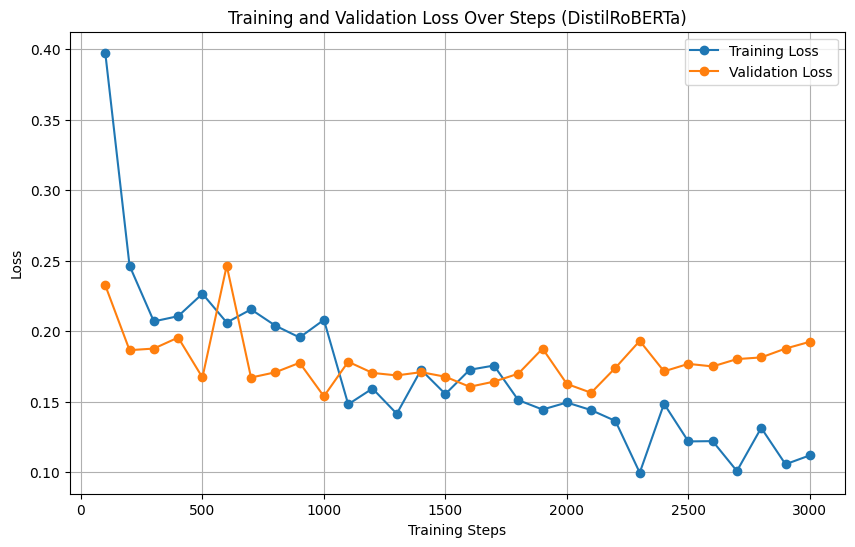

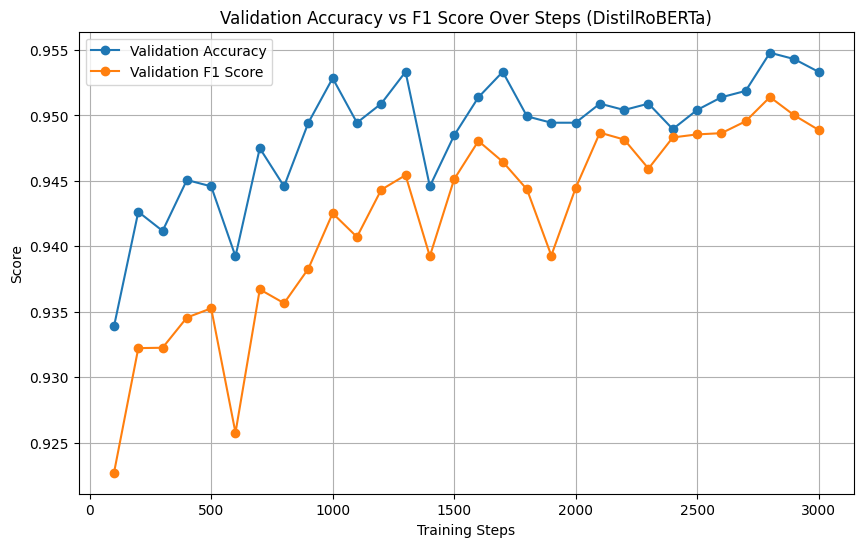


✅ Final Test Evaluation:


Accuracy: 0.9485
F1 Score: 0.9447


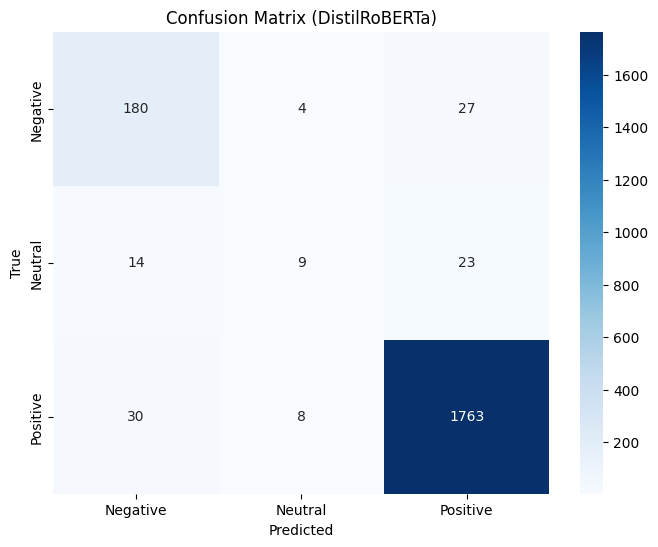

In [10]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.asarray(np.argmax(logits, axis=-1))
    labels = np.asarray(labels)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average="weighted")
    }

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="steps",  # Explicitly set to steps
    eval_steps=100,        # Evaluate every 100 steps
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,     # Log every 100 steps
    report_to="none",
    disable_tqdm=False,
    save_strategy="steps",
    save_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train model
print("Starting training...")
try:
    train_result = trainer.train()
    print("Training completed!")
except Exception as e:
    print(f"Training failed with error: {str(e)}")
    raise

# Extract training and validation metrics
train_log_history = trainer.state.log_history

# Extract training and validation loss/accuracy
train_loss = []
val_loss = []
val_accuracy = []
val_f1 = []

for log in train_log_history:
    if 'loss' in log and 'step' in log:
        train_loss.append((log['step'], log['loss']))
    if 'eval_loss' in log and 'step' in log:
        val_loss.append((log['step'], log['eval_loss']))
        val_accuracy.append((log['step'], log['eval_accuracy']))
        val_f1.append((log['step'], log['eval_f1']))

# Debug: Print logged metrics
print("Training loss entries:", train_loss)
print("Validation loss entries:", val_loss)
print("Validation accuracy entries:", val_accuracy)
print("Validation F1 entries:", val_f1)

# Plot Learning Curves (Training and Validation Loss)
plt.figure(figsize=(10, 6))
train_steps, train_loss_values = zip(*train_loss) if train_loss else ([], [])
val_steps, val_loss_values = zip(*val_loss) if val_loss else ([], [])
plt.plot(train_steps, train_loss_values, label='Training Loss', marker='o')
plt.plot(val_steps, val_loss_values, label='Validation Loss', marker='o')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Steps (DistilRoBERTa)')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/GP(AI2025)/Data/sentiment_loss_distlRoBERTa.pdf', format='pdf')
plt.show()

# Plot Validation Accuracy and F1 Score
plt.figure(figsize=(10, 6))
val_steps, val_acc_values = zip(*val_accuracy) if val_accuracy else ([], [])
val_steps, val_f1_values = zip(*val_f1) if val_f1 else ([], [])
plt.plot(val_steps, val_acc_values, label='Validation Accuracy', marker='o')
plt.plot(val_steps, val_f1_values, label='Validation F1 Score', marker='o')
plt.xlabel('Training Steps')
plt.ylabel('Score')
plt.title('Validation Accuracy vs F1 Score Over Steps (DistilRoBERTa)')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/GP(AI2025)/Data/sentiment_accuracy_distlRoBERTa.pdf', format='pdf')
plt.show()

# Evaluate on test set
print("\n✅ Final Test Evaluation:")
test_results = trainer.evaluate(tokenized_datasets["test"])
print(f"Accuracy: {test_results['eval_accuracy']:.4f}")
print(f"F1 Score: {test_results['eval_f1']:.4f}")

# Generate predictions for confusion matrix
predictions = trainer.predict(tokenized_datasets["test"])
preds = np.asarray(np.argmax(predictions.predictions, axis=1))
labels = np.asarray(predictions.label_ids)

# Plot Confusion Matrix
id2label = {0: "Negative", 1: "Neutral", 2: "Positive"}
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[id2label[i] for i in range(3)],
            yticklabels=[id2label[i] for i in range(3)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (DistilRoBERTa)')
plt.savefig('/content/drive/MyDrive/GP(AI2025)/Data/sentiment_confusionmatrix_distlRoBERTa.pdf', format='pdf')
plt.show()

In [ ]:
# RoBERTa Model Evaluation
# Final evaluation on test set
test_results = trainer.evaluate(tokenized_datasets["test"])
print("\n✅ Final Test Evaluation:")
print(f"Accuracy: {test_results['eval_accuracy']:.4f}")
print(f"F1 Score: {test_results['eval_f1']:.4f}")


✅ Final Test Evaluation:
Accuracy: 0.9543
F1 Score: 0.9499


In [ ]:
import os
import zipfile
from google.colab import files

# Define folder name for saving
model_name = "distilroberta-sentiment"
os.makedirs(model_name, exist_ok=True)

# Save model and tokenizer
trainer.save_model(model_name)
tokenizer.save_pretrained(model_name)

# Zip the folder
zip_filename = f"{model_name}.zip"
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files_ in os.walk(model_name):
        for file in files_:
            filepath = os.path.join(root, file)
            zipf.write(filepath, os.path.relpath(filepath, model_name))

# Download the zip file
files.download(zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>